In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import re
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

### EDA


In [2]:
train=pd.read_csv('Corona_NLP_train.csv')
test= pd.read_csv('Corona_NLP_test.csv')

In [3]:
train.head()

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

In [4]:
df_tr= train.copy()
df_te= test.copy()

In [5]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
df_tr.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [7]:
#Chechking for Duplicate values

df_tr[df_tr.duplicated()].sum()

UserName         0.0
ScreenName       0.0
Location         0.0
TweetAt          0.0
OriginalTweet    0.0
Sentiment        0.0
dtype: float64

In [8]:
df_tr.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [9]:
df_tr['Location'].value_counts()[:30]

London                     540
United States              528
London, England            520
New York, NY               395
Washington, DC             373
United Kingdom             337
Los Angeles, CA            281
India                      268
UK                         232
Australia                  225
USA                        223
Canada                     191
England, United Kingdom    191
Toronto, Ontario           160
Global                     159
Chicago, IL                155
California, USA            153
San Francisco, CA          152
Boston, MA                 150
New York, USA              140
New Delhi, India           138
Atlanta, GA                126
New York                   126
Mumbai, India              109
Worldwide                  101
Lagos, Nigeria              99
Texas, USA                  98
Austin, TX                  98
Houston, TX                 98
London, UK                  96
Name: Location, dtype: int64

In [10]:
df_tr['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [11]:
df_tr['Sentiment']= df_tr['Sentiment'].replace('Extremely Positive','Positive')
df_tr['Sentiment']= df_tr['Sentiment'].replace('Extremely Negative','Negative')

df_te['Sentiment']= df_te['Sentiment'].replace('Extremely Positive','Positive')
df_te['Sentiment']= df_te['Sentiment'].replace('Extremely Negative','Negative')

In [12]:
px.histogram(df_tr['Sentiment'], title='Sentiment Count')

In [13]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()

'''
0-Negative,
1-Neutral,
2-Positive
'''


df_tr['Sentiment']= le.fit_transform(df_tr['Sentiment'])

df_te['Sentiment']= le.fit_transform(df_te['Sentiment'])

### Text Preprocessing


In [14]:
text= df_tr['OriginalTweet'][0]

In [15]:
text

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [16]:
def remove_spl_char(text):
    
    text = text.lower()
    
    text = re.sub('https?://\S+|www\.\S+', ' ', text) #it's used for remove urls
    text = re.sub('<.*?>', ' ', text) #it's used for remove html parses
    text = re.sub("[^\w\s\d]", " ", text) # it's used for remove punctuations
    text = re.sub("[^a-zA-Z0-9]+", " ", text)
    
    return text

#Removing of stopwords

def remove_stopwords_and_lemmatization(text):
    final_text=[]
    text= text.lower()
    text= nltk.word_tokenize(text)
    
    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word= lemma.lemmatize(word)
            final_text.append(word)
    return " ".join(final_text)

def clean_data(data):
    text= remove_spl_char(data)
    text= remove_stopwords_and_lemmatization(text)
    return text

In [21]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
clean_text= df_tr['OriginalTweet'].apply(clean_data)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\siddhesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siddhesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\siddhesh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [22]:
df_tr['clean_text']= clean_text

In [23]:
df_tr

UserName  ScreenName                      Location     TweetAt  \
0          3799       48751                        London  16-03-2020   
1          3800       48752                            UK  16-03-2020   
2          3801       48753                     Vagabonds  16-03-2020   
3          3802       48754                           NaN  16-03-2020   
4          3803       48755                           NaN  16-03-2020   
...         ...         ...                           ...         ...   
41152     44951       89903  Wellington City, New Zealand  14-04-2020   
41153     44952       89904                           NaN  14-04-2020   
41154     44953       89905                           NaN  14-04-2020   
41155     44954       89906                           NaN  14-04-2020   
41156     44955       89907  i love you so much || he/him  14-04-2020   

                                           OriginalTweet  Sentiment  \
0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...          1   
1      advice Talk to your neighbours family to excha...          2   
2      Coronavirus Australia: Woolworths to give elde...          2   
3      My food stock is not the only one which is emp...          2   
4      Me, ready to go at supermarket during the #COV...          0   
...                                                  ...        ...   
41152  Airline pilots offering to stock supermarket s...          1   
41153  Response to complaint not provided citing COVI...          0   
41154  You know its getting tough when @KameronWilds...          2   
41155  Is it wrong that the smell of hand sanitizer i...          1   
41156  @TartiiCat Well new/used Rift S are going for ...          0   

                                              clean_text  
0                           menyrbie phil gahan chrisitv  
1      advice talk neighbour family exchange phone nu...  
2      coronavirus australia woolworth give elderly d...  
3      food stock one empty please panic enough food ...  
4      ready go supermarket covid19 outbreak paranoid...  
...                                                  ...  
41152  airline pilot offering stock supermarket shelf...  
41153  response complaint provided citing covid 19 re...  
41154  know getting tough kameronwilds rationing toil...  
41155  wrong smell hand sanitizer starting turn coron...  
41156  tartiicat well new used rift going 700 00 amaz...  

[41157 rows x 7 columns]

In [24]:
#Total Word length of the tweets

no_of_words_clean_text= df_tr['clean_text'].apply(lambda x:len(x.split(' '))).sum()
no_of_words_raw_txt = df_tr['OriginalTweet'].apply(lambda x: len(x.split(' '))).sum()

print("Summary of the total words:", end='\n')
print(f'Total words in the raw text: {no_of_words_raw_txt}')
print(f'Total words in the cleaned text:{no_of_words_clean_text}')
print(f'Removed words length:{no_of_words_raw_txt-no_of_words_clean_text}')

Summary of the total words:
Total words in the raw text: 1248202
Total words in the cleaned text:773757
Removed words length:474445


In [25]:
clean_text= df_te['OriginalTweet'].apply(clean_data)
df_te['clean_text']= clean_text

In [26]:
#Total Word length of the tweets

no_of_words_clean_text= df_te['clean_text'].apply(lambda x:len(x.split(' '))).sum()
no_of_words_raw_txt = df_te['OriginalTweet'].apply(lambda x: len(x.split(' '))).sum()

print("Summary of the total words:", end='\n')
print(f'Total words in the raw text: {no_of_words_raw_txt}')
print(f'Total words in the cleaned text:{no_of_words_clean_text}')
print(f'Removed words length:{no_of_words_raw_txt-no_of_words_clean_text}')

Summary of the total words:
Total words in the raw text: 123897
Total words in the cleaned text:75980
Removed words length:47917


Text(0.5, 1.0, 'Neural Words')

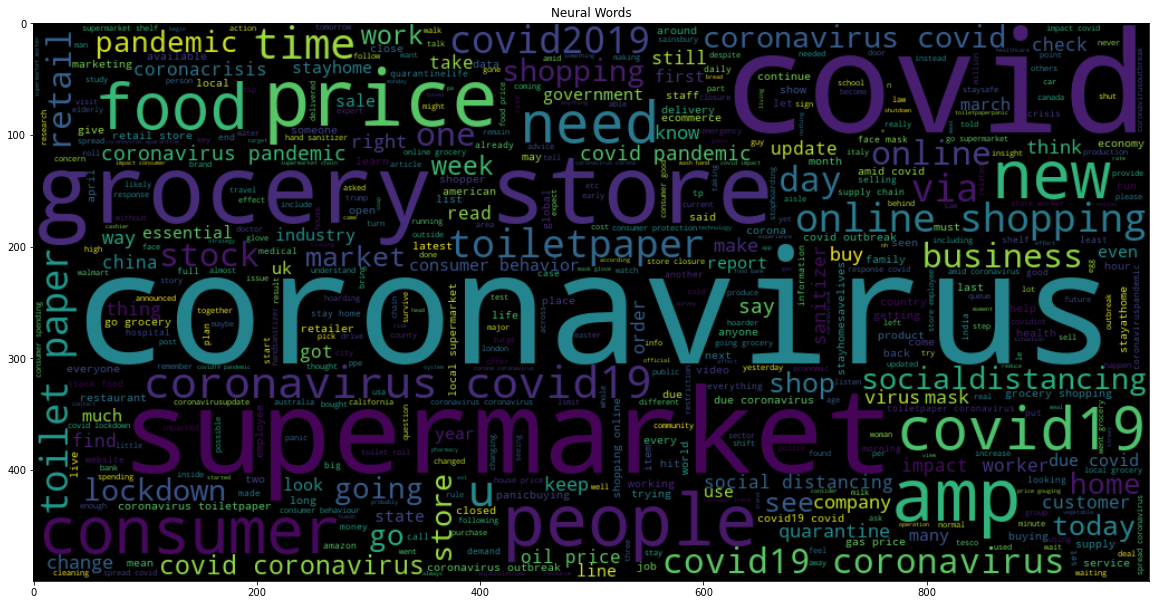

In [29]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(20,15))
wc= WordCloud(max_words=500,width=1000,height=500,
             stopwords=STOPWORDS).generate(" ".join(df_tr[df_tr['Sentiment']==1].clean_text))
plt.imshow(wc,interpolation='bilinear')
plt.title('Neural Words')

Text(0.5, 1.0, 'Negative Words')

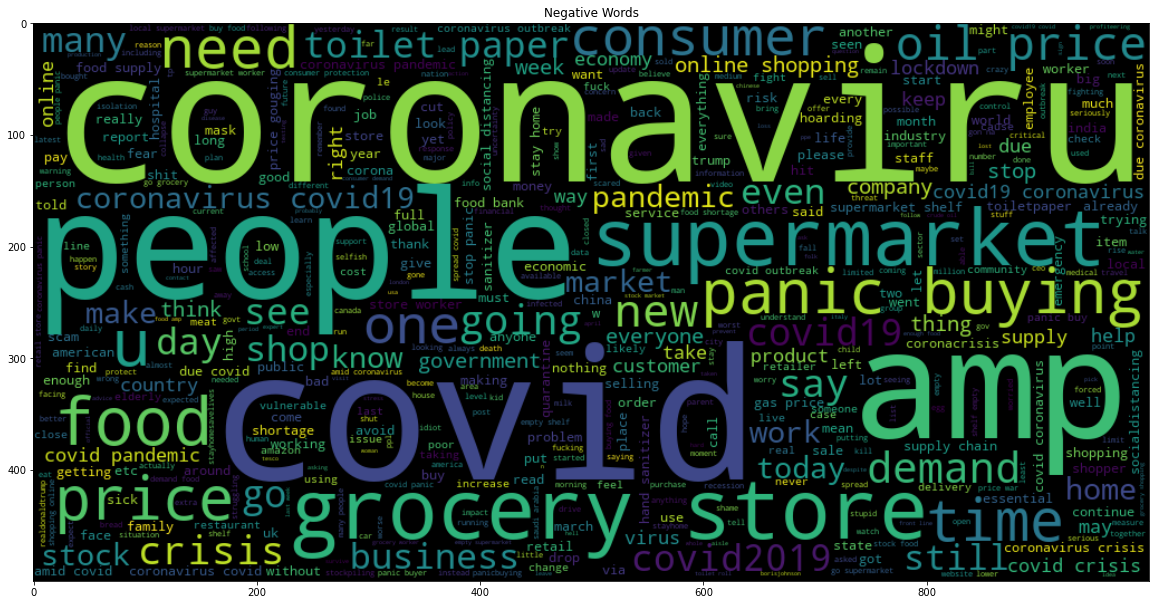

In [30]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(20,15))
wc= WordCloud(max_words=500,width=1000,height=500,
             stopwords=STOPWORDS).generate(" ".join(df_tr[df_tr['Sentiment']==0].clean_text))
plt.imshow(wc,interpolation='bilinear')
plt.title('Negative Words')

Text(0.5, 1.0, 'Positive Words')

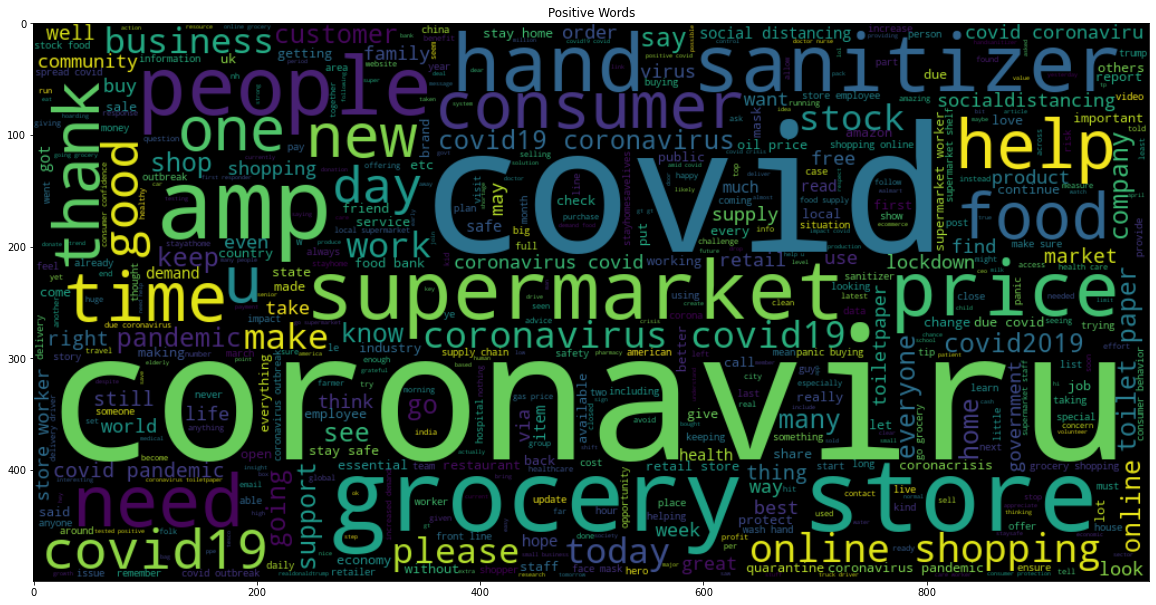

In [31]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(20,15))
wc= WordCloud(max_words=500,width=1000,height=500,
             stopwords=STOPWORDS).generate(" ".join(df_tr[df_tr['Sentiment']==2].clean_text))
plt.imshow(wc,interpolation='bilinear')
plt.title('Positive Words')

### Model Building

In [32]:
test['Sentiment']= test['Sentiment'].replace('Extremely Positive',
                                             'Positive')
test['Sentiment']= test['Sentiment'].replace('Extremely Negative',
                                             'Negative')
test['Sentiment']= le.fit_transform(test['Sentiment'])

In [33]:
x_train=df_tr['clean_text']
y_train= df_tr['Sentiment']
Y_train= df_tr['Sentiment'].values

x_test=df_te['clean_text']
y_test=df_te['Sentiment']
Y_test=df_te['Sentiment'].values

In [34]:
print("X_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (41157,)
y_train shape: (41157,)
X_test shape: (3798,)
y_test shape: (3798,)


In [35]:
#Evaluating 
num_folds = 10
seed = 7
scoring = 'accuracy'
pipelines = []
pipelines.append(('ScaledKNN',Pipeline([('trans',TfidfVectorizer()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART',Pipeline([('trans',TfidfVectorizer()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('trans',TfidfVectorizer()),('NB', MultinomialNB())])))
pipelines.append(('ScaledSGD', Pipeline([('trans',TfidfVectorizer()),('SGD', SGDClassifier())])))

results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=None)
    cv_results = cross_val_score(model,
                                 x_train,
                                 y_train,
                                 cv=kfold,
                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledKNN: 0.204365 (0.014706)
ScaledCART: 0.625824 (0.014286)
ScaledNB: 0.638311 (0.007877)
ScaledSGD: 0.773283 (0.007140)


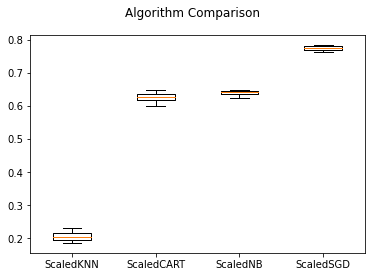

In [36]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

we can see that Multinomial Naive Bayes and Stocastic Gradient Decent have good score.

### Fine Tuning Multinomial Naive Bayes and Stocastic Gradient Decent

In [37]:
#Tuning Multinomial Naive Bayes

model_MNB = Pipeline([('trans',TfidfVectorizer()),
                     ('NB', MultinomialNB())])
tuned_parameters = {
    'NB__alpha': [1, 1e-1, 1e-2,2e-1, 3e-2],
    'NB__fit_prior': (True,False)
    }

kfold = KFold(n_splits=num_folds, random_state=None)

grid = GridSearchCV(estimator=model_MNB,
                    param_grid=tuned_parameters,
                    scoring=scoring,
                    cv=kfold)
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))


Best: 0.677309 using {'NB__alpha': 0.2, 'NB__fit_prior': False}


In [38]:
#Tuning SGD

model_SGD = Pipeline([('trans',TfidfVectorizer()),
                     ('SGD', SGDClassifier())])
tuned_parameters = {
    'SGD__penalty': ['l2', 'l1', 'elasticnet'],
    'SGD__fit_intercept':(True,False),
    'SGD__shuffle':(True,False)
    }

kfold = KFold(n_splits=num_folds, random_state=None)

grid = GridSearchCV(estimator=model_SGD,
                    param_grid=tuned_parameters,
                    scoring=scoring,
                    cv=kfold)
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))


Best: 0.804359 using {'SGD__fit_intercept': True, 'SGD__penalty': 'l1', 'SGD__shuffle': True}


### Finalising the model

In [39]:
model_final = Pipeline([('trans',TfidfVectorizer(lowercase=False)),
                     ('SGD', SGDClassifier(penalty='l1',
                                          fit_intercept=True,
                                          shuffle=True))])



In [40]:
model_final.fit(x_train,y_train)

Pipeline(steps=[('trans', TfidfVectorizer(lowercase=False)),
                ('SGD', SGDClassifier(penalty='l1'))])

In [41]:
y_pred= model_final.predict(x_test)

In [42]:
y_pred

array([0, 2, 2, ..., 1, 0, 2])

In [43]:
accuracy_score(y_test,y_pred)

0.7909426013691416

In [44]:
## saving the model
# import joblib 
# joblib.dump(model_final, 'sentiment_model_pipeline.pkl')